# Let's start with basic imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as sql

In [ ]:
db = pd.read_excel('Resultats_EEG.xlsx')

In [ ]:
display(db)

In [ ]:
#db.to_pickle('EEG_new.pkl')

# Trimming down the database
We need to trim down the database in order to keep only a certain kind of test (to not compare people writing with people doing sports, for example)

In [ ]:

request_col = "SELECT report_title, channels, hand_preference, mbti_type, analysis_version, frequency_bandwidths, executive_style, top_patterns, top_skills, average_circuit_hits_decision_making,average_circuit_hits_perception, average_circuit_hits_abstract, average_circuit_hits_concrete, average_circuit_hits_social, average_circuit_hits_technical, region_hits_circuit_hits, region_hits_regions, top_circuit_hits_hits, top_circuit_hits_circuits"
request_order = " ORDER BY channels"
request_where = ' WHERE channels = (SELECT channels FROM db GROUP BY channels ORDER BY COUNT(*) DESC LIMIT 1)'
#request_count = 

    
db_filtered = sql.sqldf(request_col + " FROM db" + request_where + request_order)




In [ ]:
display(db_filtered)
#db_filtered.to_pickle('EEG_col_utiles.pkl')

In [ ]:
db_f_activities = sql.sqldf("SELECT * FROM db_filtered WHERE LOWER(report_title) LIKE '%daily activities%'")
display(db_f_activities)

In [ ]:
#db_f_activities.to_pickle('EEG_casque_acti.pkl')

# Classification
Now that we have a database that is a bit more coherent, we can try and implement classification algorithms into it

In [2]:
db_f_activities = pd.read_pickle('EEG_casque_acti.pkl')
display(db_f_activities)

,report_title,channels,hand_preference,mbti_type,analysis_version,frequency_bandwidths,executive_style,top_patterns,top_skills,average_circuit_hits_decision_making,average_circuit_hits_perception,average_circuit_hits_abstract,average_circuit_hits_concrete,average_circuit_hits_social,average_circuit_hits_technical,region_hits_circuit_hits,region_hits_regions,top_circuit_hits_hits,top_circuit_hits_circuits
0,10 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",MIXED,ENTP,2000-01-01 00:00:00,"[""0.5:45""]",EXPEDITER,"[""OPEN_ANALYTIC"",""CENTER_FRONT"",""HALO""]","[""F8"",""T7"",""FP2"",""FC6"",""FT9"",""O1""]",49085,48223,50414.855,51236,50104.168,48922.832,"[51807,51787,51094,50757,49085,47700,51270,512...","[""C3"",""CP2"",""CZ"",""FC5"",""FP1"",""FT9"",""F3"",""FC1"",...","[1709,1526,1503,1088,805,736,713,667,590,583,5...","[""F8:FC6"",""FT9:T7"",""F8:FP2"",""O1:PO7"",""F8:FC6:F..."
1,8 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,ENTP,2000-01-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""LEFT"",""HALO""]","[""T7"",""FT9"",""P7"",""F7"",""PO7"",""O1""]",31719,31368,33445.57,34097.57,34215.168,34275.832,"[31719,34207,34092,33115,32516,33822,33630,339...","[""FP1"",""PO8"",""C3"",""F3"",""F7"",""FC1"",""FC2"",""FC5"",...","[714,583,492,391,384,383,375,346,288,278,235,2...","[""C3:C4:CP1:CP2:CP5:CP6:CZ:F3:F4:F7:F8:FC1:FC2..."
2,10 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,ESTJ,2000-01-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""HALO"",""BACK_LEFT""]","[""P7"",""PO7"",""PO8"",""O2"",""O1"",""T7""]",45221,45364,48693.145,47873.715,48048.668,48323.168,"[49714,43683,48088,47803,48880,45364,49324,485...","[""O1"",""P7"",""PO7"",""F3"",""F7"",""FP2"",""FT10"",""CP1"",...","[2632,2103,1579,1116,998,921,809,675,592,529,5...","[""P7:PO7"",""O2:PO8"",""O1:PO7"",""O1:P7:PO7"",""P7:PO..."
3,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,None,2000-01-01 00:00:00,"[""0.5:45""]",REFINER,"[""CENTER_FRONT"",""HALO"",""RANDOM_FIELD""]","[""FT9"",""T7"",""T8"",""FT10"",""F7"",""O1""]",45633,45612,45900.855,45752.57,47341.5,45346.832,"[46818,45616,48996,45956,45718,45028,48134,462...","[""F8"",""T7"",""T8"",""C3"",""F4"",""FPZ"",""CP6"",""F7"",""FC...","[1137,1120,1047,1037,1005,882,804,707,663,572,...","[""FT10:T8"",""O2:PO8"",""FT9:T7"",""O1:PO7"",""P7:PO7""..."
4,10 Daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,INFJ,2000-01-01 00:00:00,"[""0.5:45""]",EXPEDITER,"[""FRONT"",""CENTER_FRONT"",""LEFT""]","[""FT9"",""F4"",""PO8"",""O2"",""T7"",""O1""]",50956,52885,51094.57,56511.145,55959.832,56634,"[56609,53594,56395,57692,57572,57404,56973,567...","[""CZ"",""FT10"",""O1"",""PO7"",""CP1"",""CP2"",""CP6"",""P8""...","[1665,1624,1227,1063,839,709,666,625,618,583,5...","[""O2:PO8"",""F4:FT9"",""P8:PO8"",""O1:PO7"",""O2:P8:PO..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,10 daily Activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,ENTJ,2001-02-01 00:00:00,"[""8:45""]",REFINER,"[""CENTER_FRONT"",""ZIGZAG"",""SUPER_AUDIO""]","[""T8"",""FZ"",""FC2"",""F7"",""FT10"",""O1""]",160,355,1163.8572,1394.7142,1388.3334,1313.8334,"[837,1567,83,2817,2811,739,2900,1092,777,815,8...","[""CP1"",""T7"",""F4"",""F7"",""FC2"",""FC6"",""FZ"",""P7"",""C...","[353,351,312,301,290,248,193,123,105,105,81,78...","[""FC2:FZ"",""FC2:T8"",""F7:FZ"",""F7:T8"",""FZ:T8"",""F7..."
475,10 daily activities,"[""CZ"",""FZ"",""FPZ"",""FP1"",""F7"",""F3"",""FC1"",""C3"",""F...",RIGHT,None,2001-02-01 00:00:00,"[""0.5:45""]",ENERGIZER,"[""STRONG_STARBURST"",""CENTER_FRONT"",""BACK_LEFT""]","[""P7"",""T7"",""PO7"",""FT10"",""T8"",""P8""]",39210,38532,39034.715,39209.855,38635,38353.668,"[39673,40203,39579,39662,39656,39647,39748,370...","[""C3"",""CP5"",""CZ"",""F

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from pandasql import sqldf

In [4]:
# Step 1: Clean text columns
def clean_text_column(col):
    return col.apply(lambda x: ' '.join(x) if isinstance(x, list) else (str(x) if x is not None else '')).replace('', 'unknown')

db_f_activities['top_patterns'] = clean_text_column(db_f_activities['top_patterns'])
db_f_activities['top_skills'] = clean_text_column(db_f_activities['top_skills'])

# Step 2: Fix corrupted numeric columns (e.g., strings/dates in numeric columns)
# Convert to numeric safely
numeric_cols = [
    'average_circuit_hits_decision_making', 'average_circuit_hits_perception',
    'average_circuit_hits_abstract', 'average_circuit_hits_concrete',
    'average_circuit_hits_social', 'average_circuit_hits_technical'
]

for col in numeric_cols:
    db_f_activities[col] = pd.to_numeric(db_f_activities[col], errors='coerce')

# Step 3: Remove rows with NaN in any of the numeric columns
query = """
SELECT *
FROM db_f_activities
WHERE 
    average_circuit_hits_abstract IS NOT NULL AND
    average_circuit_hits_concrete IS NOT NULL AND
    average_circuit_hits_social IS NOT NULL AND
    average_circuit_hits_technical IS NOT NULL AND
    average_circuit_hits_decision_making IS NOT NULL AND
    average_circuit_hits_perception IS NOT NULL
"""
db_f_activities_clean = sqldf(query)

In [5]:
# Step 4: Separate labeled and unlabeled
labeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].notnull()]
unlabeled_df = db_f_activities_clean[db_f_activities_clean['mbti_type'].isnull()]

# Step 5: Define preprocessing pipelines
text_pipeline = TfidfVectorizer()
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

preprocessor = ColumnTransformer([
    ('text1', text_pipeline, 'top_patterns'),
    ('text2', text_pipeline, 'top_skills'),
    ('num', num_pipeline, numeric_cols)
])

# Step 6: Prepare data
X_all = preprocessor.fit_transform(db_f_activities_clean)
y_all = db_f_activities_clean['mbti_type'].fillna(-1)

# Step 7: Train semi-supervised model
base_clf = RandomForestClassifier()
self_training_clf = SelfTrainingClassifier(base_clf)
self_training_clf.fit(X_all, y_all)

SelfTrainingClassifier(base_estimator=RandomForestClassifier())

# Splitting data into train/test

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Step 1: Split labeled data into train/test
train_labeled_df, test_labeled_df = train_test_split(
    labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['mbti_type']
)

# Step 2: Combine train_labeled with unlabeled data
semi_supervised_df = pd.concat([train_labeled_df, unlabeled_df])

# Step 3: Re-prepare the input matrix
X_semi = preprocessor.fit_transform(semi_supervised_df)
y_semi = semi_supervised_df['mbti_type'].fillna(-1)

# Step 4: Train the classifier
self_training_clf = SelfTrainingClassifier(RandomForestClassifier())
self_training_clf.fit(X_semi, y_semi)

# Step 5: Preprocess test set and evaluate
X_test = preprocessor.transform(test_labeled_df)
y_test = test_labeled_df['mbti_type']

y_pred = self_training_clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        ENFJ       1.00      1.00      1.00         7
        ENFP       0.00      0.00      0.00         6
        ENTJ       0.56      0.83      0.67         6
        ENTP       0.43      0.60      0.50         5
        ESFJ       0.00      0.00      0.00         1
        ESFP       0.00      0.00      0.00         1
        ESTJ       1.00      1.00      1.00         4
        ESTP       0.00      0.00      0.00         2
        INFJ       0.40      0.29      0.33         7
        INFP       1.00      0.67      0.80         3
        INTJ       0.10      0.20      0.13         5
        INTP       0.33      0.50      0.40         6
        ISFP       0.00      0.00      0.00         1
        ISTJ       0.00      0.00      0.00         3
        ISTP       0.00      0.00      0.00         2

    accuracy                           0.46        59
   macro avg       0.32      0.34      0.32        59
weighted avg       0.42   

/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julesponce/opt/anaconda3/envs/Finance-QL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

# Confusion matrix

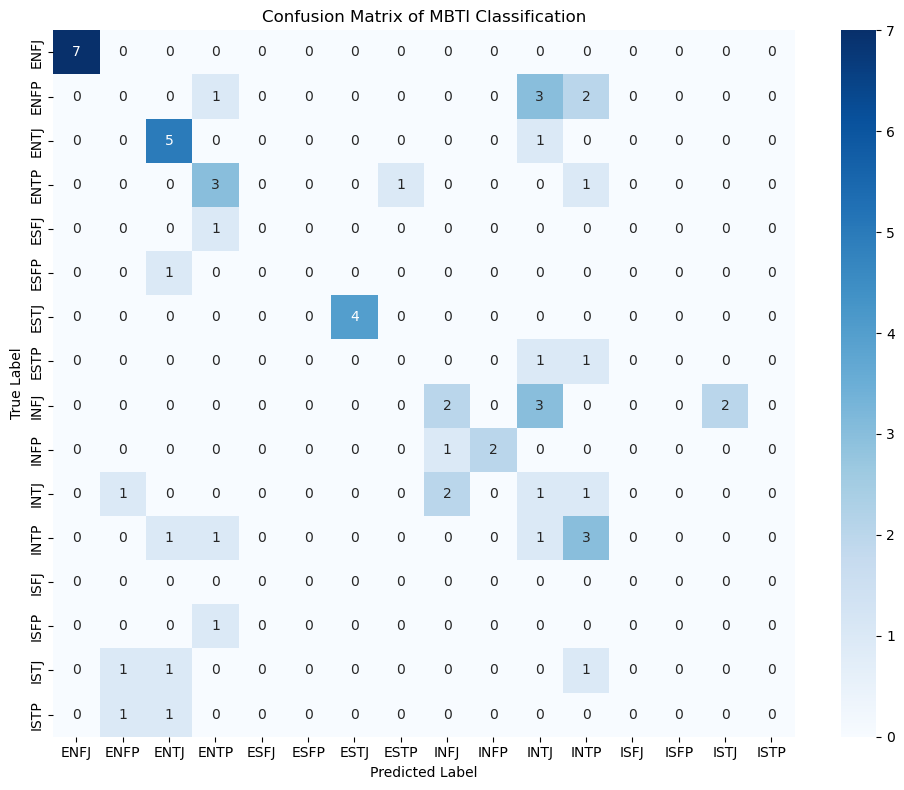

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=self_training_clf.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=self_training_clf.classes_,
            yticklabels=self_training_clf.classes_)

plt.title('Confusion Matrix of MBTI Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
